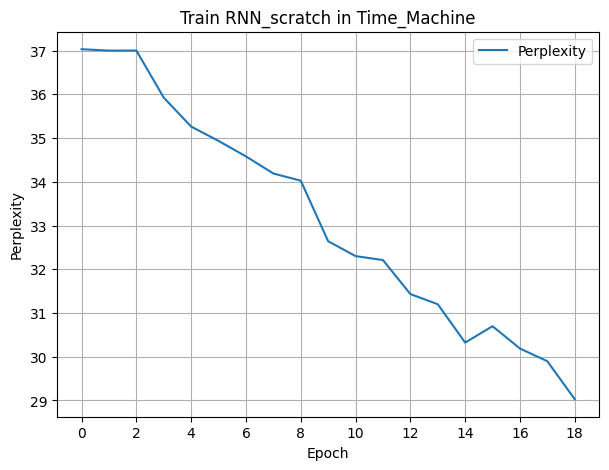

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import re
from collections import Counter
from visualization import TrainingVisualizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 设置阈值
threshold = 5

# 加载文本数据
with open('data/time_machine_txt/timemachine.txt', 'r') as f:
    text = f.read()

# 预处理文本
text = text.lower()
text = re.sub(r'[^\w\s]', '', text)
n = 3000
text = text[:n]

char_counts = Counter(text)
chars = sorted([ch for ch, count in char_counts.items() if count >= threshold])
chars.append('<unk>')

char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}
unk_idx = char_to_idx['<unk>']
text_as_int = np.array([char_to_idx.get(c, unk_idx) for c in text])

vocab_size = len(chars)
seq_size = 50
batch_size = 128
hidden_size = 256
embedding_size = 64
num_layers = 3
lr = 0.001  # 降低学习率
num_epochs = 1000  # 减少训练轮数以加快调试
dropout_prob = 0.2  # Dropout 概率

def create_dataset(text_as_int, seq_size, batch_size):
    sequences = []
    targets = []
    for i in range(0, len(text_as_int) - seq_size):
        sequences.append(text_as_int[i:i + seq_size])
        targets.append(text_as_int[i + 1:i + seq_size + 1])
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequences, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

dataloader = create_dataset(text_as_int, seq_size, batch_size)

def initialize_Wb(embedding_size, hidden_size, vocab_size, num_layers, device):
    params = []
    input_size = embedding_size
    for layer in range(num_layers):
        W_xh = torch.nn.init.xavier_uniform_(torch.empty(input_size, hidden_size, device=device))
        W_hh = torch.nn.init.xavier_uniform_(torch.empty(hidden_size, hidden_size, device=device))
        b_h = torch.zeros((1, hidden_size), device=device)
        params.append((W_xh, W_hh, b_h))
        input_size = hidden_size
    W_hq = torch.nn.init.xavier_uniform_(torch.empty(hidden_size, vocab_size, device=device))
    b_q = torch.zeros((1, vocab_size), device=device)
    params.append((W_hq, b_q))
    for param_group in params:
        for param in param_group:
            param.requires_grad_(True)
    return params

def initialize_H(batch_size, hidden_size, num_layers, device):
    H = [torch.zeros((batch_size, hidden_size), device=device) for _ in range(num_layers)]
    return H

def RNN_calculate(inputs, params, H, num_layers, dropout_prob, device):
    outputs = []
    layer_params = params[:-1]
    W_hq, b_q = params[-1]
    for X in inputs:
        for layer in range(num_layers):
            W_xh, W_hh, b_h = layer_params[layer]
            H[layer] = torch.tanh(torch.mm(X, W_xh) + torch.mm(H[layer], W_hh) + b_h)
            X = F.dropout(H[layer], p=dropout_prob, training=True)  # 添加 Dropout
        O = torch.mm(X, W_hq) + b_q
        outputs.append(O)
    outputs = torch.stack(outputs)
    return outputs, H

class RNNModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers, dropout_prob, initialize_Wb, initialize_H, RNN_calculate, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.params = initialize_Wb(embedding_size, hidden_size, vocab_size, num_layers, device)
        self.initialize_H = initialize_H
        self.RNN_calculate = RNN_calculate

    def forward(self, X, H):
        X = self.embedding(X)
        X = X.permute(1, 0, 2).to(self.device)
        Y, H = self.RNN_calculate(X, self.params, H, self.num_layers, self.dropout_prob, self.device)
        return Y, H

    def begin_H(self, batch_size, hidden_size, num_layers, device):
        return self.initialize_H(batch_size, hidden_size, num_layers, device)

def text_prediction(prefix, num_preds, net, device):
    H = net.begin_H(1, hidden_size, num_layers, device)
    outputs = [char_to_idx[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]]).reshape((1, 1))
    for char in prefix[1:]:
        _, H = net(get_input(), H)
        outputs.append(char_to_idx[char])
    for _ in range(num_preds):
        Y, H = net(get_input(), H)
        outputs.append(int(Y.argmax(dim=2).reshape(1)))
    return ''.join([idx_to_char[i] for i in outputs])

def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def RNN_train_epoch(train_iter, model, criterion, optimizer, device):
    H = None
    for X, Y in train_iter:
        if H is None:
            H = model.begin_H(X.shape[0], hidden_size, num_layers, device)
        else:
            H = [h.detach() for h in H]
        Y = Y.T
        Y_hat, H = model(X, H)
        Y_hat = Y_hat.reshape(-1, Y_hat.shape[2])
        Y = Y.reshape(-1)
        Y_hat, Y = Y_hat.to(device), Y.to(device)
        optimizer.zero_grad()
        loss = criterion(Y_hat, Y.long()).mean()
        loss.backward()
        grad_clipping(model, 1)
        optimizer.step()
        perplexity = math.exp(loss)
    return perplexity

def RNN_train(model, train_iter, lr, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)  # 使用Adam优化器
    visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Perplexity', title='Train RNN_scratch in Time_Machine', legend=['Perplexity'])
    predict = lambda prefix: text_prediction(prefix, 50, model, device)
    for epoch in range(num_epochs):
        perplexity = RNN_train_epoch(train_iter, model, criterion, optimizer, device)
        visualizer.add(epoch, [perplexity])

model = RNNModel(embedding_size, hidden_size, vocab_size, num_layers, dropout_prob, initialize_Wb, initialize_H, RNN_calculate, device)
RNN_train(model, dataloader, lr, num_epochs, device)